<a href="https://colab.research.google.com/github/OSA7JIMI/SC3000/blob/main/easy_ra0004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

^C
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
^C
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 7.5 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


## Import dependencies, define helper functions, initialise environment

In [21]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

env = gym.make("CartPole-v1")

## Task 1: Development of an RL agent

A Q-learning agent is applied in this task. To obtain the Q-table, an epsilon-greedy strategy with exploration rate of 0.1 was used to choose actions. The Q-values were calculated using the formula given in the lecture slides: new estimation = old estimation + learning rate(new sample - old estimation). The learning rate is set at 0.1 and the discount value at 0.9


After the Q-table has been populated, the agent returns the optimal action directly from the table without any randomness.

In [20]:
def table_agent(state):
    if random.random()< 0.1:
        return random.randint(0,1)
    else:
        return np.argmax(q_table[state])

def update_table(state, action, reward, future):
    best = np.argmax(q_table[future])
    target = reward + 0.9*q_table[future, best]
    error = target - q_table[state, action]
    q_table[state, action] += 0.1*error

def test_agent(state):
    return np.argmax(q_table[state])

Since the original observation is an array containing continuous values, it must first be converted into a discrete state space. A total of 20 states were used to represent observations. States 0-15 are used to represent the binary values of whether each element of the observation is more than 0.

As initial observations showed that the most common termination reason was the cart travelling out of the screen, extreme values of position and velocity must be accounted for. States 16-19 represent these danger zones. Since the event of the pendulum swinging more than 12 degrees was rarely observed, states were not allocated to represent this danger.

The order of the return statements is arranged from highest to lowest priority, starting with dangerous position, then dangerous velocity, then the observations in binary.

In [22]:
def tuning_converter(observation, pos_proportion, v_proportion):
    if observation[0] > 2.4*pos_proportion:
        return 16
    if observation[0] < -2.4*pos_proportion:
        return 17
    if observation[1] > 4*v_proportion:
        return 18
    if observation[1] < -4*v_proportion:
        return 19

    pos = observation[0] > 0
    v = observation[1] > 0
    ang = observation[2] > 0
    av = observation[3] > 0
    state = pos*8 + v*4 + ang*2 + av
    return state

In order to define danger zones optimally, fine tuning of the boundaries was performed. From environment rules and initial observations, the maximum position is set at +/- 2.4 and the maximum velocity is set at +/- 4. 4 proportions (75%, 80%, 85%, 90%) are tested by populating the Q-table with 10 sets of 100 episodes and testing it on another 10 sets of 100 episodes. The mean reward for each set of episodes is calculated and the proportions with the highest minimum mean are taken as the optimal hyperparameters.

In [23]:
best_min = 0
best_p = 0
best_v = 0
best_q = np.zeros((20,2))

for p in [0.75, 0.8, 0.85, 0.9]:
    for v in [0.75, 0.8, 0.85, 0.9]:
        q_table = np.zeros((20,2))

        for i in range(10):
            for j in range(100):
                observation = env.reset()
                cumulative_reward = 0
                done = False
                while not done:
                    state = tuning_converter(observation, p, v)
                    action = table_agent(state)
                    observation, reward, done, info = env.step(action)
                    future = tuning_converter(observation, p, v)
                    cumulative_reward += reward
                    update_table(state, action, cumulative_reward, future)

        episode_means = []
        for i in range(10):
            episode_results = np.array([])
            for j in range(100):
                observation = env.reset()
                cumulative_reward = 0
                done = False
                while not done:
                    state = tuning_converter(observation, p, v)
                    action = test_agent(state)
                    observation, reward, done, info = env.step(action)
                    cumulative_reward += reward
                episode_results = np.append(episode_results,cumulative_reward)
            episode_means.append(episode_results.mean())

        if min(episode_means) > best_min:
            best_min = min(episode_means)
            best_p = p
            best_v = v
            best_q = q_table

        print(min(episode_means), p, v)

print()
print('Best Minimum Mean, Best P, Best V')
print(best_min, best_p, best_v)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


65.56 0.75 0.75
46.2 0.75 0.8
31.67 0.75 0.85
131.11 0.75 0.9
120.86 0.8 0.75
79.37 0.8 0.8
43.27 0.8 0.85
64.88 0.8 0.9
224.85 0.85 0.75
66.52 0.85 0.8
183.76 0.85 0.85
66.0 0.85 0.9
39.81 0.9 0.75
183.68 0.9 0.8
93.58 0.9 0.85
199.66 0.9 0.9

Best Minimum Mean, Best P, Best V
224.85 0.85 0.75


The Q-table is set to the one with the optimal hyperparameters. Note that the danger states for velocity are still 0, indicating that the agent has not learned enough about these states to assign them values. 

In [24]:
q_table = best_q
q_table

array([[ 991.44071795,  802.09373448],
       [ 707.46946548,  804.57676144],
       [ 442.13552196,  591.95627817],
       [ 437.6916562 ,  510.55640201],
       [ 805.39815473,  448.2235345 ],
       [ 472.08917058,   58.55296128],
       [ 534.45274473,  483.56208621],
       [ 450.81317528,  546.08749912],
       [ 549.19761376,  500.35676589],
       [ 504.79014388,  561.78427884],
       [ 307.73013845,  771.67692003],
       [ 577.13545682,  583.08411579],
       [ 512.27688563,  466.56939819],
       [ 554.94876911,  552.26842394],
       [ 685.52963721,  586.98994539],
       [ 623.30265704,  696.19111126],
       [1757.40788915, 1878.50100828],
       [1780.99078782, 1440.94080455],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ]])

For Task 1, the observation and chosen action is shown below:

In [27]:
observation = env.reset()
state = tuning_converter(observation, best_p, best_v)
action = test_agent(state)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.01036726 -0.01124073 -0.03915063  0.01073031]
Chosen action: 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, the agent developed in Task 1 played the game for 100 episodes. The cumulative reward for each episode was recorded and plotted on the graph. 

In [28]:
episode_results = []
for i in range(100):
    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        state = tuning_converter(observation, best_p, best_v)
        action = test_agent(state)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    episode_results.append(cumulative_reward)

The graph shows a decent result with a minimum reward of approximately 125 and 5 instances of truncation (reward = 500).

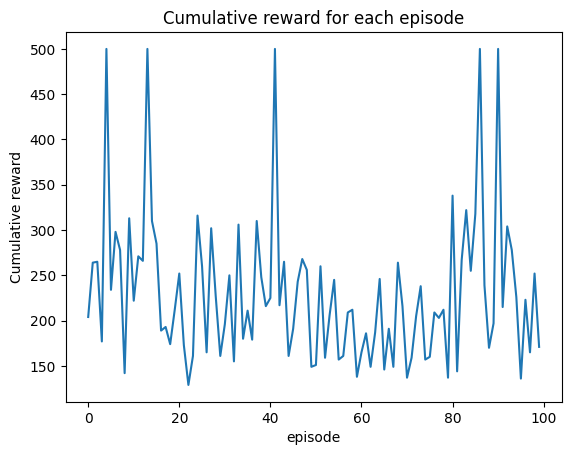

In [29]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

The average reward over the 100 episodes is sufficiently high

In [32]:
mean = sum(episode_results)/100
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 230.03
Is my agent good enough? True


## Task 3: Render one episode played by the agent

The video of an episode is displayed below.

In [35]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    state = tuning_converter(observation, best_p, best_v)
    action = test_agent(state)
    observation, reward, done, info = env.step(action)
    if done:
        break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
